<a href="https://colab.research.google.com/github/ramapriyakp/Data-Analysis/blob/master/Identify_Blood_Cell_Subtypes_From_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. 

**Dataset** : 
This dataset contains 12,500 images of blood cells (JPEG) with accompanying cell type labels (CSV). There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type). The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. 

- Each image has multiple blood cells in it. 
- On average it would probably be 10 cells per image.
- The cell-of-interest is colored purple while other cells are colored skin-red.
- One cell-of-interest per image

# Solution

**Goal**: Identify the cell-type of cell-of-interest.

**Benefits**

Automated methods to detect and classify blood cell subtypes have important medical applications.
The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications.

# Data Preparation

## Step One: Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#import required packages
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import DL libraries opencv & Keras 
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop,Adam


#import scikit learn & its utilities
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#import utility packages
import xml.etree.ElementTree as ET
import itertools
import os
import csv


Using TensorFlow backend.


In [0]:
dict_characters1 = {0:'NEUTROPHIL',1:'EOSINOPHIL',2:'MONOCYTE',3:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
dict_characters= dict_characters1

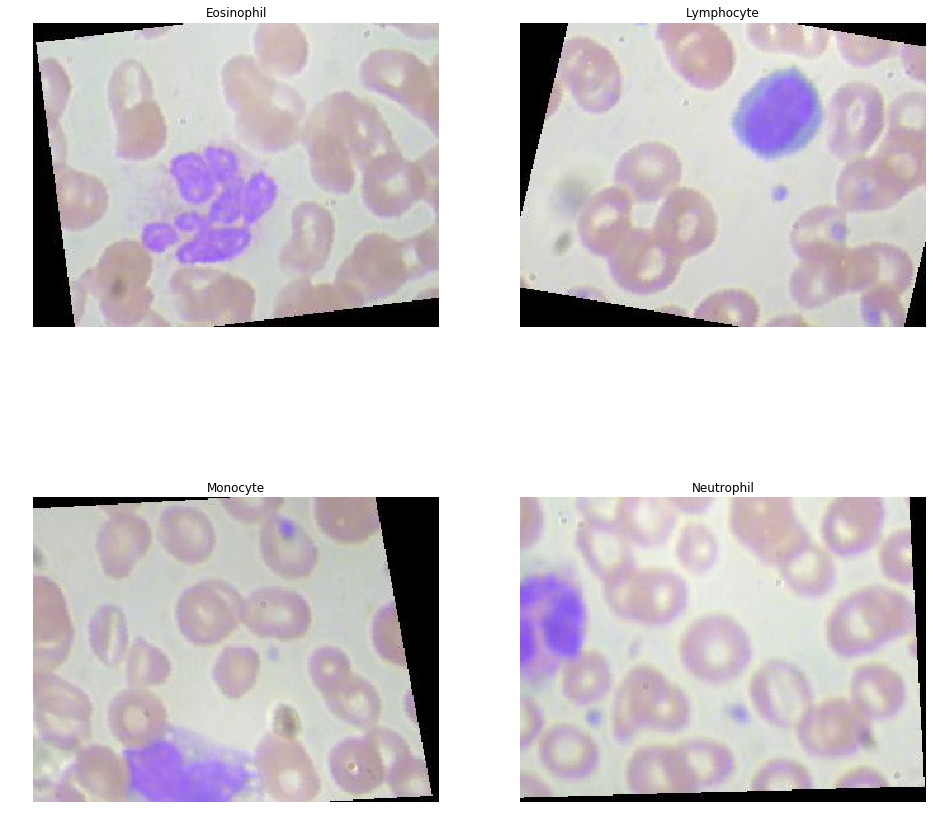

In [5]:
#**************
#Plot Image
#**************
def plotImage(image_location):
    image = cv2.imread(image_location)   # BGR
    image = image[:, :, [2, 1, 0]]       # Reorder to RGB for Matplotlib display
    plt.imshow(image)
    return

plt.figure(figsize=(16,16))
plt.subplot(221)
image_name = '/content/gdrive/My Drive/CNN/in/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
#plt.subplot

image_name = '/content/gdrive/My Drive/CNN/in/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)

image_name = '/content/gdrive/My Drive/CNN/in/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)

plt.subplot(224)
image_name = '/content/gdrive/My Drive/CNN/in/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

## Manual Identification

- **Limphocyte**: looks like well rounded purple colored potato. These are the easiest to identify.

- **Monocyte**: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the purple color is never fully covering the cell surface. Also, the purple colored portion of the cell is always in one continuous piece.

- **Neutrophil**: The cell shape lookes roundish with skin-red color with some purple stuff inside. However the cell contains purple colored multiple whole-groundnuts inside it. The groundnuts could be disjointed within the cell.

- **Eosinophil**: They look like Neutrophils. Alas! See the confusion matrix published by paultimothymooney. In his kernel, most of the failures happen when predictor falsly thinks that Eosinophils are Neutrophils.


- **Mononuclear** : Basophil + Lymphocyte vs Monocyte 

- **Polynuclear** : Neutrophil + Eosinophil

## Step Three: Load Input Dataset

In [6]:
from tqdm import tqdm

def get_data(folder):
    """
    Load data, labels from  given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label_cell    = 0
                label_nuclues = 1        
            elif wbc_type in ['EOSINOPHIL']:
                label_cell    = 1
                label_nuclues = 1
            elif wbc_type in ['MONOCYTE']:
                label_cell    = 2  
                label_nuclues = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label_cell    = 3 
                label_nuclues = 0 
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    #Resize the images to size=(60, 80)
                    img_file = cv2.resize(img_file, (80, 60), interpolation = cv2.INTER_AREA)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)       # image array
                    y.append(label_cell)    # Cell type label 
                    z.append(label_nuclues) # nucleus type label
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

# Load train and test datasets:
X_train, y_train, z_train = get_data('/content/gdrive/My Drive/CNN/in/TRAIN/')
X_test, y_test, z_test    = get_data('/content/gdrive/My Drive/CNN/in/TEST/') 

# Encode labels to hot vectors  
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train)
y_testHot = to_categorical(y_test)
z_trainHot = to_categorical(z_train)
z_testHot = to_categorical(z_test)
print(dict_characters)
print(dict_characters2)

100%|██████████| 624/624 [02:47<00:00,  3.70it/s]

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


## Step Four: Describe Dataset

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}


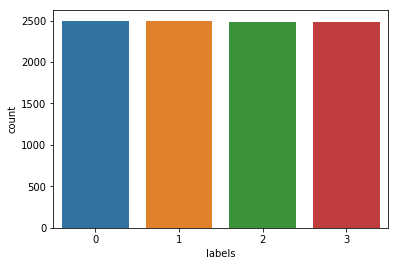

In [7]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

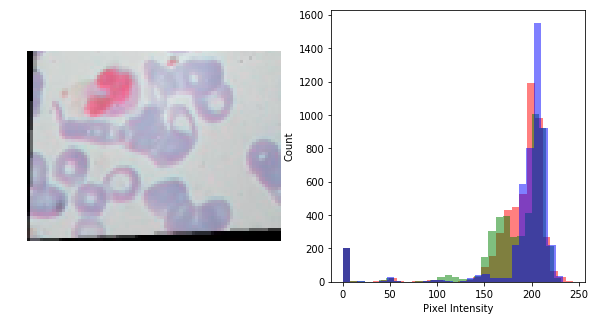

In [8]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    
    
plotHistogram(X_train[1])

## Step Five:  Preprocess Dataset

**Normalize Pixel Values** :
Neural networks process inputs using small weight values, and inputs with large integer values
can disrupt or slow down the learning process. As such it is good practice to normalize the pixel
values so that each pixel value has a value between 0 and 1.



In [0]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

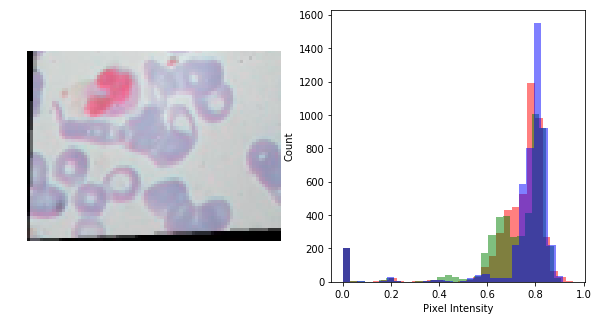

In [10]:
plotHistogram(X_train[1])

## Train the CNN model

   **CNN Architecture**                                                     
![image.png](attachment:image.png)

We use Keras Sequential API to define CNN network. 
Here we add on one layer at a time, starting from the input.

**Convolutional layer**: The primary purpose of Convolution in case of a ConvNet is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data.  The _‘filter‘ (‘kernel’ ,‘feature detector’)_ with its weights rotates over the image matrix in a sliding window fashion to produce a _feature map( ‘Convolved Feature’ or ‘Activation Map’)_. The kernel matrix behaves like a filter in an image extracting particular information from the original image matrix.  

**MaxPooling** layers just look at four neighboring pixels and picks the maximal value. This reduces the size of the image by half, and by combining convolutional and pooling layers, the net be able to combine its features to learn more global features of the image. Spatial Pooling (also called subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum etc.

**Activation function** is used to make output non-linear. In CNN, output of convolution is passed through  activation function like _ReLU_ activation function.

**Fully connected layer**  purpose is to use features output from convolutional and pooling layer for classifying input image into various classes based on the training dataset. 

**Batch Normalization** is a technical trick to make training faster.

**Dropout** is a _regularization_ method, where the layer randomly replaces a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization. 

## Define Helper Functions

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')    

In [0]:
import keras
 

def runKerasCNNAugment(i_train,o_train,i_test,o_test,stride):
    #batch_size = 128
    num_classes = len(o_train[0])
    epochs = 30
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)

    #  Define CNN model
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape,strides=stride))
    model.add(BatchNormalization()) 
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
     
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    #  Compile CNN model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= Adam(lr=1e-4),
                  metrics=['accuracy'])
    
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,   # set each sample mean to 0
        zca_whitening=False,       # apply ZCA whitening
        fill_mode='nearest',       # set mode for filling points outside the input boundaries
        rotation_range=10,         # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,     # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,    # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,      # randomly flip images
        vertical_flip=False)       # randomly flip images
    
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(i_train, o_train, batch_size=32),
                        steps_per_epoch=len(i_train) / 32, epochs=epochs, 
                        validation_data = [i_test,o_test],callbacks = [MetricsCheckpoint('logs')])
    
    # Score trained model.
    score = model.evaluate(i_test,o_test, verbose=0)
    print('\nKeras CNN validation- accuracy:', score[1],'\n')
    
    y_pred = model.predict(i_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(o_test > 0)[1],
                                                      np.argmax(y_pred, axis=1), 
                                                      target_names=list(map_characters.values())), 
                                                      sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(o_test,axis=1)
    
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
312/311 [==============================] - 18s 57ms/step - loss: 1.4691 - acc: 0.3396 - val_loss: 1.3376 - val_acc: 0.4186
Epoch 2/30
312/311 [==============================] - 14s 43ms/step - loss: 1.2007 - acc: 0.4452 - val_loss: 1.2585 - val_acc: 0.4033
Epoch 3/30
312/311 [==============================] - 13s 43ms/step - loss: 1.0106 - acc: 0.5368 - val_loss: 1.9357 - val_acc: 0.3969
Epoch 4/30
312/311 [==============================] - 15s 47ms/step - loss: 0.8545 - acc: 0.6044 - val_loss: 1.8283 - val_acc: 0.4298
Epoch 5/30
312/311 [==============================] - 13s 43ms/step - loss: 0.7644 - acc: 0.6469 - val_loss: 0.8308 - val_acc: 0.6204
Epoch 6/30
312/311 [==============================] - 13s 43ms/step - loss: 0.6941 - acc: 0.688

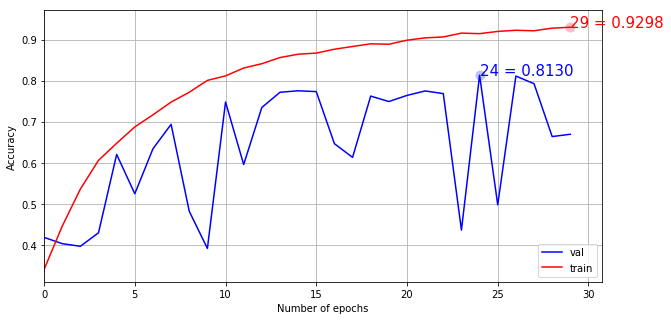

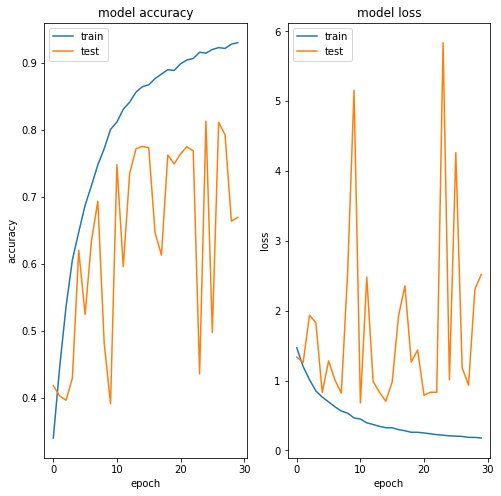

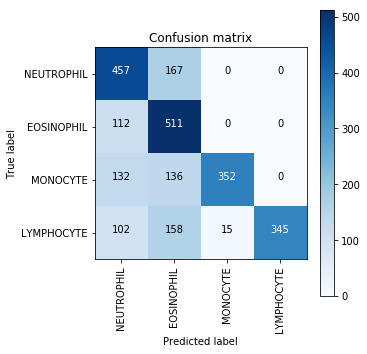

In [13]:
dict_characters = dict_characters1
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)  


Epoch 1/30
312/311 [==============================] - 13s 41ms/step - loss: 0.7922 - acc: 0.5817 - val_loss: 0.7172 - val_acc: 0.5533
Epoch 2/30
312/311 [==============================] - 13s 41ms/step - loss: 0.5587 - acc: 0.6970 - val_loss: 0.6373 - val_acc: 0.6365
Epoch 3/30
312/311 [==============================] - 13s 41ms/step - loss: 0.4448 - acc: 0.7751 - val_loss: 0.5594 - val_acc: 0.6900
Epoch 4/30
312/311 [==============================] - 12s 39ms/step - loss: 0.3689 - acc: 0.8262 - val_loss: 0.4771 - val_acc: 0.7487
Epoch 5/30
312/311 [==============================] - 12s 39ms/step - loss: 0.3091 - acc: 0.8547 - val_loss: 0.5053 - val_acc: 0.7648
Epoch 6/30
312/311 [==============================] - 12s 39ms/step - loss: 0.2458 - acc: 0.8859 - val_loss: 0.4430 - val_acc: 0.8291
Epoch 7/30
312/311 [==============================] - 12s 39ms/step - loss: 0.2042 - acc: 0.9087 - val_loss: 1.0400 - val_acc: 0.8138
Epoch 8/30
312/311 [==============================] - 12s 39ms

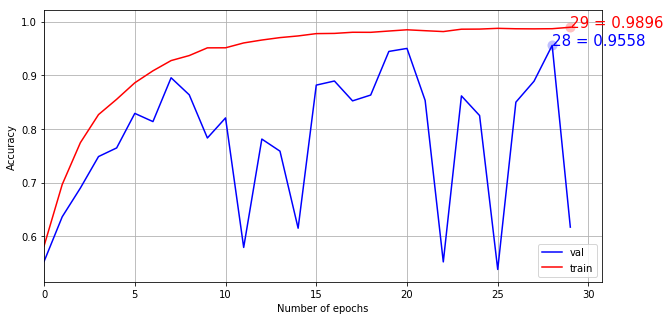

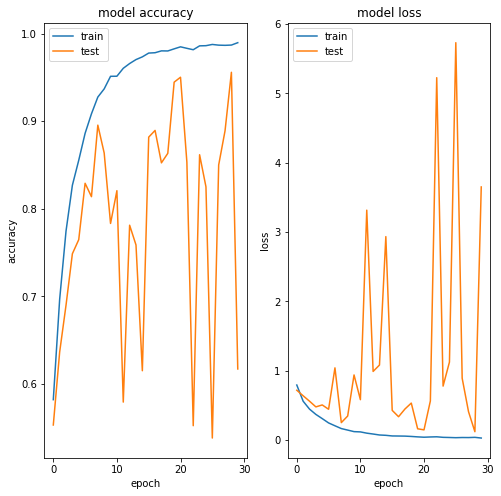

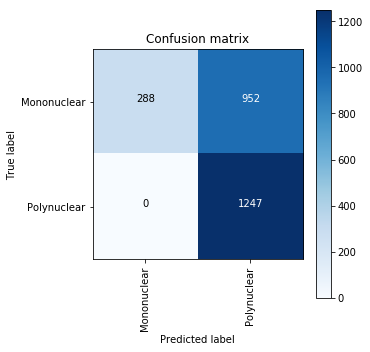

In [14]:
dict_characters = dict_characters2
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2)   
